<a href="https://colab.research.google.com/github/No-Qubit-Left-Behind/NQLB/blob/master/Tutorial/TF_CRAB_Legendre_Robust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propagator

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.signal as sp_signal
import time
print(tf.__version__)

2.3.0


In [38]:
class PropagatorVL:
    def __init__(self, input_dim, no_of_steps, delta_t):
        self.delta_t = delta_t
        self.duration = no_of_steps * delta_t
        """
            contraction_array determines the neccessity for the extra
            matrix multiplication step in the recursive method self.propagate()
            when the intermediate computation array has length not divisible
            by 2
        """
        self.contraction_array = self.gen_contraction_array(no_of_steps)
        self.Legendre_basis_matrix = self.gen_Legendre_matrix(
            input_dim, no_of_steps
        )

        self.x = tf.constant(
            [[0, 1], [1, 0]], dtype=tf.complex128
        )
        self.y = tf.constant(
            [[0 + 0j, 0 - 1j], [0 + 1j, 0 + 0j]], dtype=tf.complex128
        )
        
        """
            Van Loan generators for control robustness
        """
        xL = -2 * np.pi *(0 + 1j) * np.block([
            [self.x.numpy(), self.x.numpy()],
            [np.zeros((2, 2)), self.x.numpy()]          
        ])
        yL = -2 * np.pi *(0 + 1j) * np.block([
            [self.y.numpy(), self.y.numpy()],
            [np.zeros((2, 2)), self.y.numpy()]          
        ])

        self.generators =  tf.stack([
                                     tf.constant(xL, dtype=tf.complex128),
                                     tf.constant(yL, dtype=tf.complex128)
                                     ])

        self.ctrl_amplitudes = tf.Variable(
            tf.zeros([input_dim, 2], dtype=tf.float64), dtype=tf.float64
        )

    @staticmethod
    def gen_contraction_array(no_of_intervals):
        if no_of_intervals > 1:
            return (
                [bool(np.mod(no_of_intervals, 2))] +
                PropagatorVL.gen_contraction_array(
                    np.floor(no_of_intervals / 2)
                )
            )
        return []

    @staticmethod
    def gen_Legendre_matrix(input_dim, output_dim):
        def Legendre_basis_vector(Legendre_coefficients):
            return np.polynomial.legendre.Legendre(
                tuple(Legendre_coefficients)
            ).linspace(output_dim)[1]
        Legendre_basis_vectors = tuple(map(
            Legendre_basis_vector, np.eye(input_dim)
        ))
        return tf.constant(
            np.column_stack(Legendre_basis_vectors), dtype = tf.float64
        )

    """
        regularize_amplitudes ensures that no individual amplitude exceeds 1
    """
    def regularize_amplitudes(self, amplitudes):
        amplitude_norms = tf.math.sqrt(
            tf.math.square(amplitudes[:, 0]) + tf.math.square(amplitudes[:, 1])
        )
        normalization_factor = tf.math.tanh(amplitude_norms) / amplitude_norms
        return tf.math.multiply(
            tf.stack([normalization_factor, normalization_factor], 1),
            amplitudes
        )

    def return_physical_amplitudes(self):
        transformed_amplitudes = tf.linalg.matmul(
            self.Legendre_basis_matrix, self.ctrl_amplitudes
        )
        normalized_amplitudes = self.regularize_amplitudes(
            transformed_amplitudes
        )
        return normalized_amplitudes    

    """
        exponentials() computes a vector matrix exponential after multiplying
        each self.ctrl_amplitudes row with a the vector of matrices in
        self.generators
    """
    def exponentials(self):
        physical_amplitudes = self.return_physical_amplitudes()
        exponents = tf.linalg.tensordot(
            tf.cast(physical_amplitudes, dtype=tf.complex128),
            self.delta_t * self.generators, 1
        )
        return tf.linalg.expm(exponents)
    
    """
        propagate  computes the final propagator by recursively multiplying
        each odd element in the list of matrices with each even element --
        if the length of the array is not divisible by 2 an extra computation
        step is added
    """
    def propagate(self):
        step_exps = self.exponentials()
        for is_odd in self.contraction_array:
            if is_odd:
                odd_exp = step_exps[-1, :, :]
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0:-1:2, :, :]
                )
                step_exps = tf.concat([
                    step_exps[0:-1, :, :],
                    [tf.linalg.matmul(odd_exp, step_exps[-1, :, :])]
                ], 0)
            else:
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0::2, :, :]
                )
        return tf.squeeze(step_exps)

    """
        __call__ computes the final propagator fidelity squared with the
        identity operator
    """
    def metrics(self):
        propagator = self.propagate()
        tr = tf.linalg.trace(tf.linalg.matmul(self.x, propagator[0:2, 0:2]))
        """
            infidelity part in the target
        """
        infidelity = 1 - tf.math.real(tr * tf.math.conj(tr)) / (2 ** 2)
        """
            robustness term in the target
        """
        norm_squared = 1 / ((2 * np.pi * self.duration) ** 2) / 2 * (
            tf.math.real(
                tf.linalg.trace(
                    tf.linalg.matmul(
                        propagator[0:2, 2:4],
                        propagator[0:2, 2:4],
                        adjoint_b=True
                    )
                )
            )
        )

        return infidelity, norm_squared
 
    @tf.function
    def target(self):
        infidelity, robust_metric = self.metrics()
        return 0.5 * infidelity + 0.5 * robust_metric

nt = 1000
del_t = 0.001
time = np.linspace(0, nt * del_t, nt)

basis_dim = 4

propagatorVL = PropagatorVL(basis_dim, nt, del_t)

optimizer = tf.keras.optimizers.Adam(0.01)

propagatorVL.ctrl_amplitudes.assign(
    tf.random.uniform([basis_dim, 2], -1, 1, dtype=tf.float64)
)

def optimization_step():
    with tf.GradientTape() as tape:
        current_target = propagatorVL.target()
    gradients = tape.gradient(current_target, [propagatorVL.ctrl_amplitudes])
    optimizer.apply_gradients(zip(gradients, [propagatorVL.ctrl_amplitudes]))
    return current_target

steps = range(2000)
for step in steps:
    current_target = optimization_step()
    if step % 50 == 0:
        print('step %2d: target=%2.5f' %
              (step, current_target))
    
final = propagatorVL.return_physical_amplitudes().numpy()


step  0: target=0.73060
step 50: target=0.11503
step 100: target=0.06938
step 150: target=0.04708
step 200: target=0.03683
step 250: target=0.03227
step 300: target=0.03028
step 350: target=0.02937
step 400: target=0.02886
step 450: target=0.02845
step 500: target=0.02797
step 550: target=0.02733
step 600: target=0.02646
step 650: target=0.02523
step 700: target=0.02350
step 750: target=0.02112
step 800: target=0.01801
step 850: target=0.01435
step 900: target=0.01066
step 950: target=0.00757


final infidelity = 0.00062


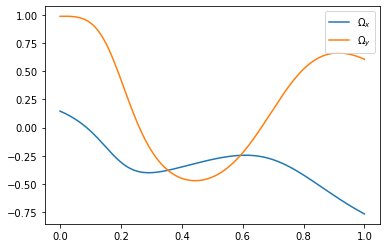

In [41]:
#Get final control amplitudes:
amplitudes = propagatorVL.return_physical_amplitudes().numpy()

plt.figure()
plt.plot(time, amplitudes[:, 0], label = '$\Omega_x$')
plt.plot(time, amplitudes[:, 1], label = '$\Omega_y$')
plt.legend()

print('final infidelity = %2.5f' %propagatorVL.metrics()[0])
